In [37]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error

In [38]:
def preprocess_kwh(freq: str = "D") -> pd.DataFrame:
    df = pd.read_csv(
        "../data/og_data/Energie_KWh_15_min.csv",
        delimiter=";",
        parse_dates=["timestamp"],
        dayfirst=True,
        na_values="NULL"
    )
    numeric = df.columns.drop("timestamp")
    df[numeric] = (
        df[numeric]
        .astype(float)
        .ffill()
        .diff()
        .clip(lower=0, upper=200)
        .fillna(0)
    )
    df = df.set_index("timestamp").resample(freq).sum().reset_index()
    df["timestamp"] = df["timestamp"].dt.normalize()
    return df


def preprocess_freq(freq: str = "D") -> pd.DataFrame:
    df = pd.read_csv(
        "../data/og_data/frequentie.csv",
        delimiter=";",
        parse_dates=["interval_15min"],
        dayfirst=True,
        na_values="NULL"
    ).rename(columns={"interval_15min": "timestamp"})
    df = (
        df.set_index("timestamp")
          .resample(freq)
          .mean()
          .reset_index()
    )
    df["timestamp"] = df["timestamp"].dt.normalize()
    return df[["timestamp", "v_19"]].rename(columns={"v_19": "frequentie"})

In [39]:
def forecast_efficiency_weighted(
    freq: str = "D",
    train_end: str = "2024-01-01",
    periods: int | None = None,
):
    if periods is None:
        periods = {"D": 365, "H": 365 * 24, "W": 52}.get(freq, 365)

    kwh_df = preprocess_kwh(freq)
    freq_df = preprocess_freq(freq)
    df = pd.merge(kwh_df, freq_df, on="timestamp").rename(columns={"timestamp": "ds"})
    kwh_cols = kwh_df.columns.drop("timestamp")

    n = len(kwh_cols)
    fig, axs = plt.subplots(math.ceil(n / 2), 2, figsize=(14, 5 * math.ceil(n / 2)))
    axs = axs.flatten()

    for i, col in enumerate(kwh_cols):
        ax = axs[i]
        data = df[["ds", col, "frequentie"]].rename(columns={col: "y"}).sort_values("ds")

        # clean frequency: replace zeros, then ffill/bfill
        data["frequentie"] = (
            data["frequentie"]
            .replace(0, np.nan)
            .ffill()
            .bfill()
        )

        # drop leading zero/null y
        valid_idxs = data.index[(data["y"].notna()) & (data["y"] != 0)]
        if valid_idxs.empty:
            ax.axis("off")
            ax.text(0.5, 0.5, f"No valid data for {col}", ha="center")
            continue
        data = data.loc[valid_idxs.min():].reset_index(drop=True)

        if data["y"].nunique() <= 1:
            ax.axis("off")
            ax.text(0.5, 0.5, f"{col}: constant load", ha="center")
            continue

        train = data[data["ds"] <= pd.to_datetime(train_end)]
        if train.empty:
            ax.axis("off")
            ax.text(0.5, 0.5, f"{col}: no training data ≤ {train_end}", ha="center")
            continue

        beta = train["y"].sum() / train["frequentie"].sum()
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=(freq == "D"),
            daily_seasonality=(freq == "H"),
        )
        m.add_regressor("frequentie")
        m.fit(train)

        future = m.make_future_dataframe(periods=periods, freq=freq)
        future = future.merge(data[["ds", "frequentie"]], on="ds", how="left")
        future["frequentie"] = (
            future["frequentie"]
            .ffill()
            .bfill()
        )

        fcst = m.predict(future).set_index("ds")
        freq_hat = fcst["frequentie"]
        baseline_line = beta * freq_hat

        ax.plot(fcst.index, fcst["yhat"], label="Prophet yhat")
        ax.plot(baseline_line.index, baseline_line, "--", label="Baseline β·Hz")
        ax.set_title(f"{col}: β = {beta:.3f} kWh/Hz")
        ax.legend()

    for j in range(n, len(axs)): axs[j].axis("off")
    plt.tight_layout()
    plt.show()

In [40]:
def compute_hvac_inefficiency(
    freq: str = "D",
    baseline_window_days: int = 365,
    periods: int | None = None,
    cost_per_kwh: float = 0.25,
    plot: bool = True,
) -> pd.DataFrame:
    if periods is None:
        periods = {"D": 365, "W": 52}.get(freq, 365)

    kwh_df = preprocess_kwh(freq)
    freq_df = preprocess_freq(freq)
    df = pd.merge(kwh_df, freq_df, on="timestamp").rename(columns={"timestamp": "ds"})
    kwh_cols = kwh_df.columns.drop("timestamp")
    results = []

    if plot:
        fig, axs = plt.subplots(len(kwh_cols), 3, figsize=(18, 4 * len(kwh_cols)))
        if len(kwh_cols) == 1: axs = np.expand_dims(axs, 0)

    for idx, col in enumerate(kwh_cols):
        data = df[["ds", col, "frequentie"]].rename(columns={col: "y"}).sort_values("ds")
        data["frequentie"] = (
            data["frequentie"].replace(0, np.nan).ffill().bfill()
        )

        valid_idxs = data.index[(data["y"].notna()) & (data["y"] != 0)]
        if valid_idxs.empty: continue
        data = data.loc[valid_idxs.min():].reset_index(drop=True)

        start = data.loc[0, "ds"]
        end = start + pd.Timedelta(days=baseline_window_days - 1)
        base_df = data[(data["ds"] >= start) & (data["ds"] <= end)]
        if base_df.empty: continue

        beta = base_df["y"].sum() / base_df["frequentie"].sum()
        m = Prophet(yearly_seasonality=True, weekly_seasonality=(freq == "D"))
        m.add_regressor("frequentie")
        m.fit(data)

        future = m.make_future_dataframe(periods=periods, freq=freq)
        future = future.merge(data[["ds", "frequentie"]], on="ds", how="left")
        future["frequentie"] = future["frequentie"].ffill().bfill()
        fcst = m.predict(future).set_index("ds")

        # Build full DF without overlapping columns
        full = pd.DataFrame({
            "yhat": fcst["yhat"],
            "frequentie": fcst["frequentie"]
        }, index=fcst.index)
        full["y"] = data.set_index("ds")["y"].reindex(full.index)
        full["y"] = full["y"].fillna(full["yhat"])

        full["expected"]    = beta * full["frequentie"]
        full["excess_kwh"]  = (full["y"] - full["expected"]).clip(lower=0)
        full["excess_cost"] = full["excess_kwh"] * cost_per_kwh
        full["cum_cost"]    = full["excess_cost"].cumsum()

        results.append({
            "channel": col,
            "baseline_beta_kWh_per_Hz": beta,
            "excess_cost": full["excess_cost"].sum(),
            "inefficiency_%":
                full["excess_kwh"].sum() / full["expected"].sum() * 100,
        })

        if plot:
            ax1, ax2, ax3 = axs[idx]
            full[["y", "expected"]].plot(ax=ax1)
            ax1.set_title(f"{col}: Actual vs Expected")
            full["excess_kwh"].plot(ax=ax2)
            ax2.set_title("Excess kWh")
            full["cum_cost"].plot(ax=ax3)
            ax3.set_title(f"Cum Cost (€{cost_per_kwh}/kWh)")

    if plot:
        plt.tight_layout()
        plt.show()
    return pd.DataFrame(results)


18:20:29 - cmdstanpy - INFO - Chain [1] start processing
18:20:29 - cmdstanpy - INFO - Chain [1] done processing
18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing
18:20:30 - cmdstanpy - INFO - Chain [1] start processing
18:20:30 - cmdstanpy - INFO - Chain [1] done processing
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
18:20:31 - cmdstanpy - INFO - Chain [1] start processing
18:20:31 - cmdstanpy - INFO - Chain [1] done processing
18:20:32 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:32 - cmdstanpy - INFO - Chain [1] start processing
18:20:32 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1] done processing
18:20:33 - cmdstanpy - INFO - Chain [1] start processing
18:20:33 - cmdstanpy - INFO - Chain [1]

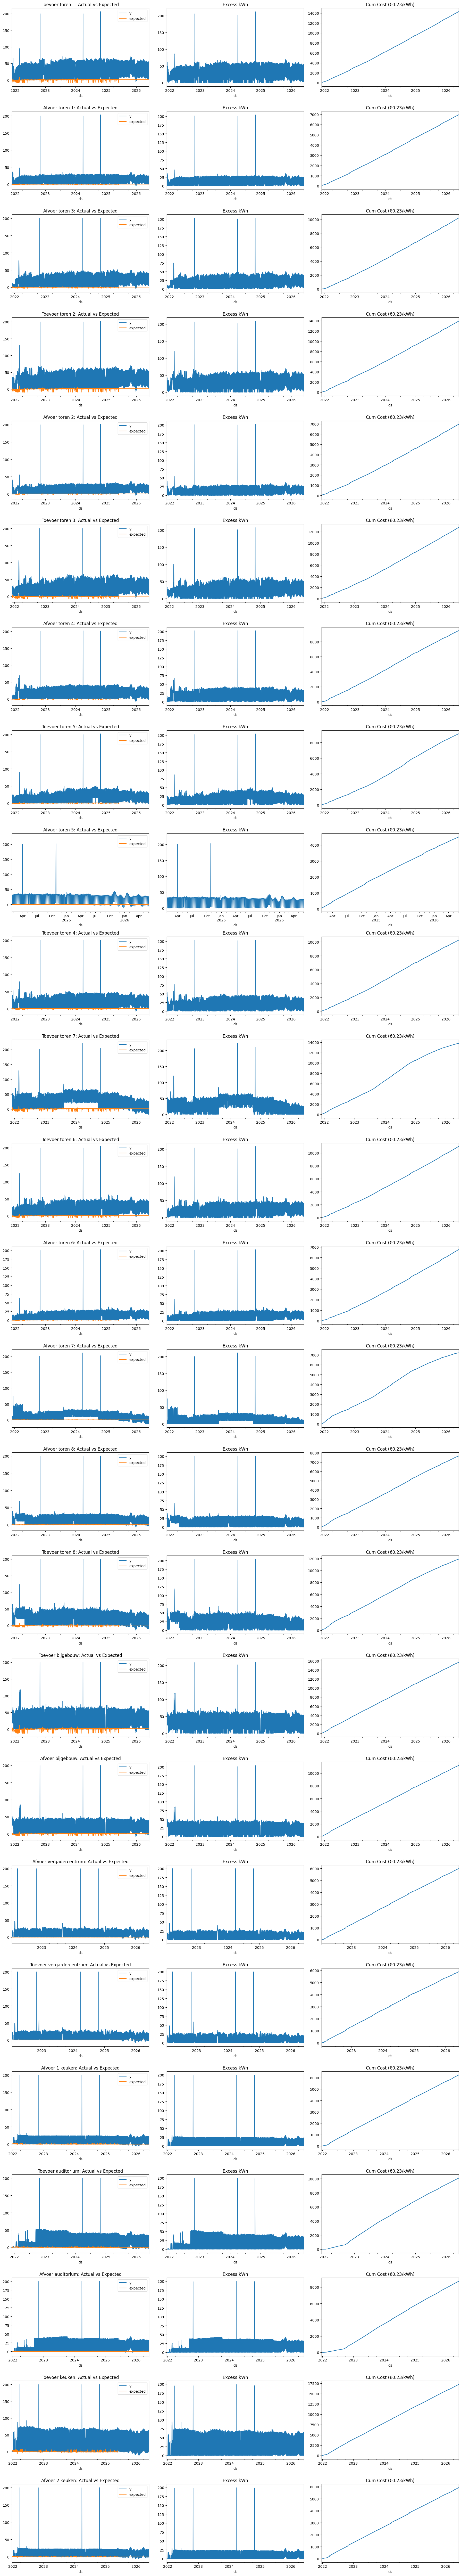

                     channel  baseline_beta_kWh_per_Hz   excess_cost  \
0            Toevoer toren 1                  1.000273  14283.062874   
1             Afvoer toren 1                  0.506658   6949.835199   
2             Afvoer toren 3                  0.660831  10177.880064   
3            Toevoer toren 2                  0.987899  13929.365294   
4             Afvoer toren 2                  0.480154   6958.938257   
5            Toevoer toren 3                  0.817464  12765.129279   
6             Afvoer toren 4                  0.670945   9472.275840   
7            Toevoer toren 5                  0.567106   9115.842832   
8             Afvoer toren 5                  0.676486   4501.202362   
9            Toevoer toren 4                  0.724454  10250.348981   
10           Toevoer toren 7                  1.035933  13804.278404   
11           Toevoer toren 6                  0.735657  10996.241381   
12            Afvoer toren 6                  0.411513   6753.20

In [41]:
df_summary = compute_hvac_inefficiency(
     freq="D",
     baseline_window_days=365,
     periods=365,
     cost_per_kwh=0.23,
 )
print(df_summary)

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from prophet import Prophet

# -----------------------------------------------------------------------------
# 1. DATA PRE-PROCESSING HELPERS
# -----------------------------------------------------------------------------

def preprocess_kwh(freq: str = "D") -> pd.DataFrame:
    df = pd.read_csv(
        "../data/og_data/Energie_KWh_15_min.csv",
        delimiter=";",
        parse_dates=["timestamp"],
        dayfirst=True,
        na_values="NULL"
    )
    # convert cumulative readings to per-period usage
    numeric = df.columns.drop("timestamp")
    df[numeric] = (
        df[numeric]
        .astype(float)
        .ffill()
        .diff()
        .clip(lower=0, upper=200)
        .fillna(0)
    )
    df = df.set_index("timestamp").resample(freq).sum().reset_index()
    df["timestamp"] = df["timestamp"].dt.normalize()
    return df


def preprocess_freq(freq: str = "D") -> pd.DataFrame:
    df = pd.read_csv(
        "../data/og_data/frequentie.csv",
        delimiter=";",
        parse_dates=["interval_15min"],
        dayfirst=True,
        na_values="NULL"
    ).rename(columns={"interval_15min": "timestamp"})
    df = (
        df.set_index("timestamp")
          .resample(freq)
          .mean()
          .reset_index()
    )
    df["timestamp"] = df["timestamp"].dt.normalize()
    return df[["timestamp", "v_19"]].rename(columns={"v_19": "frequentie"})

# -----------------------------------------------------------------------------
# 2. FORECAST & NAIVE BASELINE
# -----------------------------------------------------------------------------

def forecast_efficiency_weighted(
    freq: str = "D",
    baseline_periods: int | None = None,
    forecast_periods: int | None = None
) -> None:
    """
    Plot Prophet forecast vs. naive baseline from first positive usage.

    Baseline is computed from the first `baseline_periods` periods after
    the first strictly positive kWh reading.
    """
    if baseline_periods is None:
        baseline_periods = {"D": 365, "W": 52}.get(freq, 365)
    if forecast_periods is None:
        forecast_periods = baseline_periods

    kwh_df = preprocess_kwh(freq)
    freq_df = preprocess_freq(freq)
    df = pd.merge(kwh_df, freq_df, on="timestamp", how="inner").rename(columns={"timestamp": "ds"})
    channels = kwh_df.columns.drop("timestamp")

    n = len(channels)
    cols = 2
    rows = math.ceil(n/cols)
    fig, axs = plt.subplots(rows, cols, figsize=(14, 5*rows))
    axs = axs.flatten()

    for i, ch in enumerate(channels):
        ax = axs[i]
        data = (
            df[["ds", ch, "frequentie"]]
            .rename(columns={ch: "y"})
            .sort_values("ds")
            .reset_index(drop=True)
        )
        # clean frequency
        data["frequentie"] = data["frequentie"].replace(0, np.nan).ffill().bfill()

        # drop all leading zeros and NaNs in kWh
        pos = data.index[data["y"] > 0]
        if pos.empty:
            ax.axis("off")
            ax.text(0.5, 0.5, f"No positive usage for {ch}", ha="center")
            continue
        first = pos.min()
        data = data.loc[first:].reset_index(drop=True)

        # compute baseline coefficient β using first baseline_periods
        n_base = min(baseline_periods, len(data))
        base_df = data.iloc[:n_base]
        beta = base_df["y"].sum() / base_df["frequentie"].sum()

        # fit Prophet on full history
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=(freq == "D"),
            daily_seasonality=(freq == "H"),
        )
        m.add_regressor("frequentie")
        m.fit(data)

        # future frame & forecast
        future = m.make_future_dataframe(periods=forecast_periods, freq=freq)
        future = future.merge(data[["ds", "frequentie"]], on="ds", how="left")
        future["frequentie"] = future["frequentie"].ffill().bfill()
        fcst = m.predict(future).set_index("ds")

        # naive baseline line
        baseline_line = beta * fcst["frequentie"]

        # plot
        ax.plot(fcst.index, fcst["yhat"], label="Prophet yhat")
        ax.plot(baseline_line.index, baseline_line, "--", label=f"Baseline β={beta:.4f}")
        ax.set_title(ch)
        ax.legend()

    # disable unused subplots
    for j in range(n, rows*cols): axs[j].axis("off")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
# 3. INEFFICIENCY & COST CALCULATION
# -----------------------------------------------------------------------------

def compute_hvac_inefficiency(
    freq: str = "D",
    baseline_periods: int | None = None,
    forecast_periods: int | None = None,
    cost_per_kwh: float = 0.25,
    plot: bool = True
) -> pd.DataFrame:
    """
    Returns summary of excess kWh and cost per channel vs. naive baseline.
    """
    if baseline_periods is None:
        baseline_periods = {"D": 365, "W": 52}.get(freq, 365)
    if forecast_periods is None:
        forecast_periods = baseline_periods

    kwh_df = preprocess_kwh(freq)
    freq_df = preprocess_freq(freq)
    df = pd.merge(kwh_df, freq_df, on="timestamp", how="inner").rename(columns={"timestamp": "ds"})
    channels = kwh_df.columns.drop("timestamp")

    results = []
    if plot:
        fig, axs = plt.subplots(len(channels), 3, figsize=(18, 4*len(channels)))
        if len(channels) == 1: axs = np.expand_dims(axs, 0)

    for idx, ch in enumerate(channels):
        data = (
            df[["ds", ch, "frequentie"]]
            .rename(columns={ch: "y"})
            .sort_values("ds")
            .reset_index(drop=True)
        )
        # clean frequency
        data["frequentie"] = data["frequentie"].replace(0, np.nan).ffill().bfill()

        # drop leading zeros
        pos = data.index[data["y"] > 0]
        if pos.empty:
            continue
        first = pos.min()
        data = data.loc[first:].reset_index(drop=True)

        # baseline coefficient
        n_base = min(baseline_periods, len(data))
        base_df = data.iloc[:n_base]
        beta = base_df["y"].sum() / base_df["frequentie"].sum()

        # fit & forecast
        m = Prophet(yearly_seasonality=True, weekly_seasonality=(freq == "D"))
        m.add_regressor("frequentie")
        m.fit(data)
        future = m.make_future_dataframe(periods=forecast_periods, freq=freq)
        future = future.merge(data[["ds", "frequentie"]], on="ds", how="left")
        future["frequentie"] = future["frequentie"].ffill().bfill()
        fcst = m.predict(future).set_index("ds")

        # build full DF
        full = pd.DataFrame({
            "yhat": fcst["yhat"],
            "frequentie": fcst["frequentie"]
        }, index=fcst.index)
        full["y"] = data.set_index("ds")["y"].reindex(full.index).fillna(full["yhat"])

        # metrics
        full["expected"] = beta * full["frequentie"]
        full["excess_kwh"] = (full["y"] - full["expected"]).clip(lower=0)
        full["excess_cost"] = full["excess_kwh"] * cost_per_kwh
        full["cum_cost"] = full["excess_cost"].cumsum()

        results.append({
            "channel": ch,
            "baseline_beta_kWh_per_Hz": beta,
            "excess_cost": full["excess_cost"].sum(),
            "inefficiency_%": full["excess_kwh"].sum() / full["expected"].sum() * 100
        })

        # optional plots
        if plot:
            ax1, ax2, ax3 = axs[idx]
            full[["y", "expected"]].plot(ax=ax1)
            ax1.set_title(f"{ch}: Actual vs Expected")
            full["excess_kwh"].plot(ax=ax2)
            ax2.set_title("Excess kWh")
            full["cum_cost"].plot(ax=ax3)
            ax3.set_title(f"Cum Cost (€{cost_per_kwh}/kWh)")

    if plot:
        plt.tight_layout()
        plt.show()
    return pd.DataFrame(results)

# Usage examples:
# forecast_efficiency_weighted('D')  # daily
# forecast_efficiency_weighted('W')  # weekly
# df_summary = compute_hvac_inefficiency('D', baseline_periods=365, forecast_periods=365, cost_per_kwh=0.23)
# print(df_summary)


18:25:55 - cmdstanpy - INFO - Chain [1] start processing
18:25:55 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:56 - cmdstanpy - INFO - Chain [1] done processing
18:25:56 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:57 - cmdstanpy - INFO - Chain [1] start processing
18:25:57 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1] done processing
18:25:58 - cmdstanpy - INFO - Chain [1] start processing
18:25:58 - cmdstanpy - INFO - Chain [1]

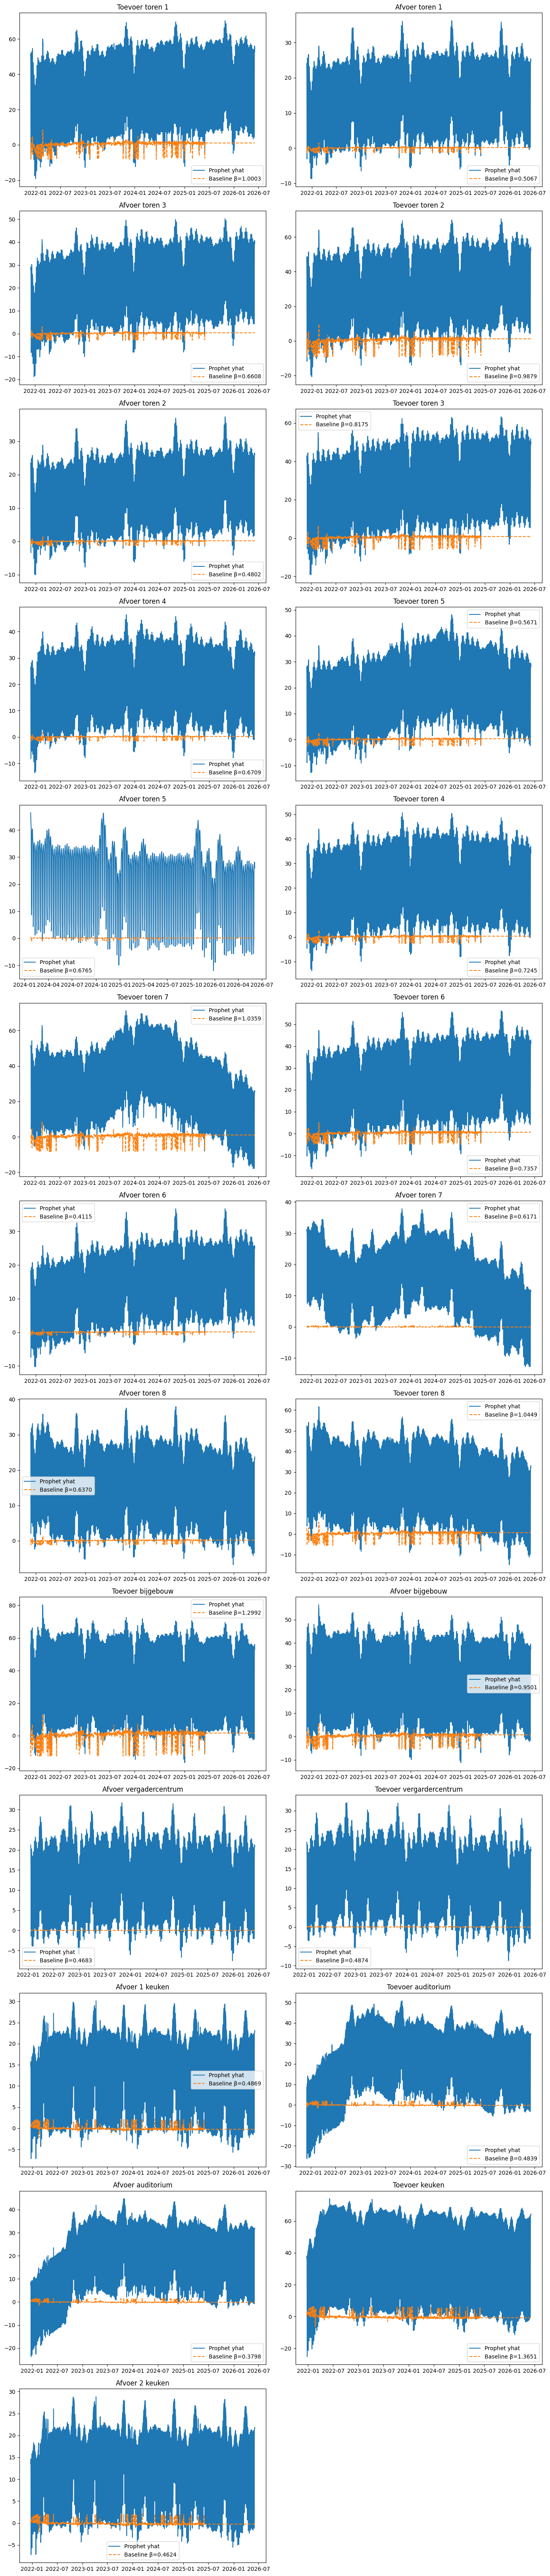

18:26:07 - cmdstanpy - INFO - Chain [1] start processing
18:26:07 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1] done processing
18:26:08 - cmdstanpy - INFO - Chain [1] start processing
18:26:08 - cmdstanpy - INFO - Chain [1]

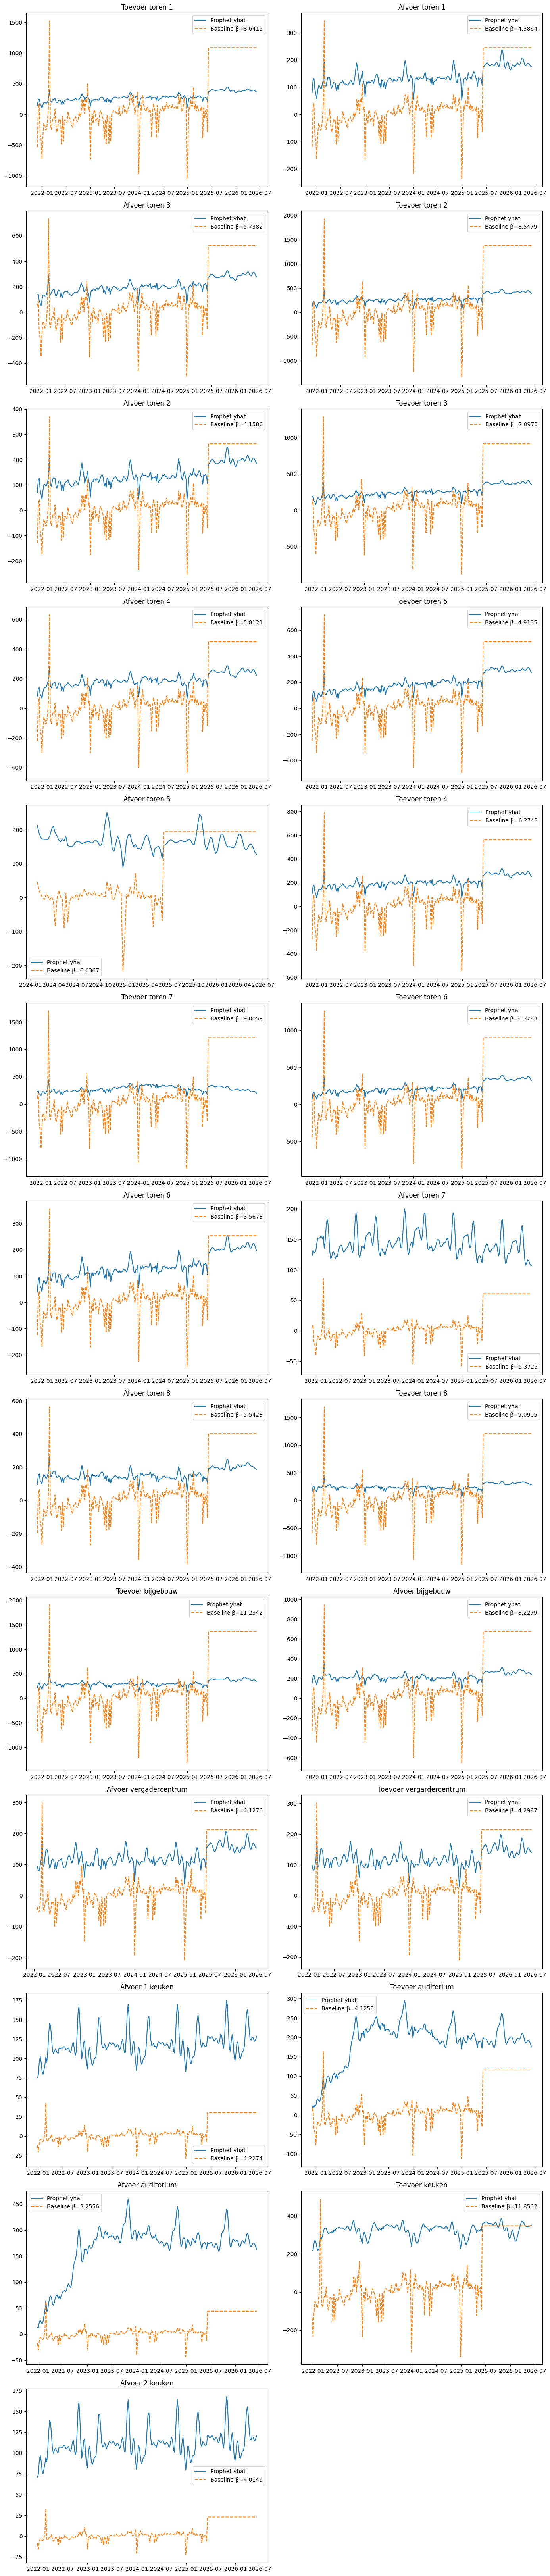

18:26:13 - cmdstanpy - INFO - Chain [1] start processing
18:26:13 - cmdstanpy - INFO - Chain [1] done processing
18:26:13 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing
18:26:14 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing
18:26:14 - cmdstanpy - INFO - Chain [1] start processing
18:26:14 - cmdstanpy - INFO - Chain [1] done processing
18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:15 - cmdstanpy - INFO - Chain [1] done processing
18:26:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:15 - cmdstanpy - INFO - Chain [1] done processing
18:26:16 - cmdstanpy - INFO - Chain [1] start processing
18:26:16 - cmdstanpy - INFO - Chain [1] done processing
18:26:16 - cmdstanpy - INFO - Chain [1] start processing
18:26:16 - cmdstanpy - INFO - Chain [1] done processing
18:26:17 - cmdstanpy - INFO - Chain [1] start processing
18:26:17 - cmdstanpy - INFO - Chain [1]

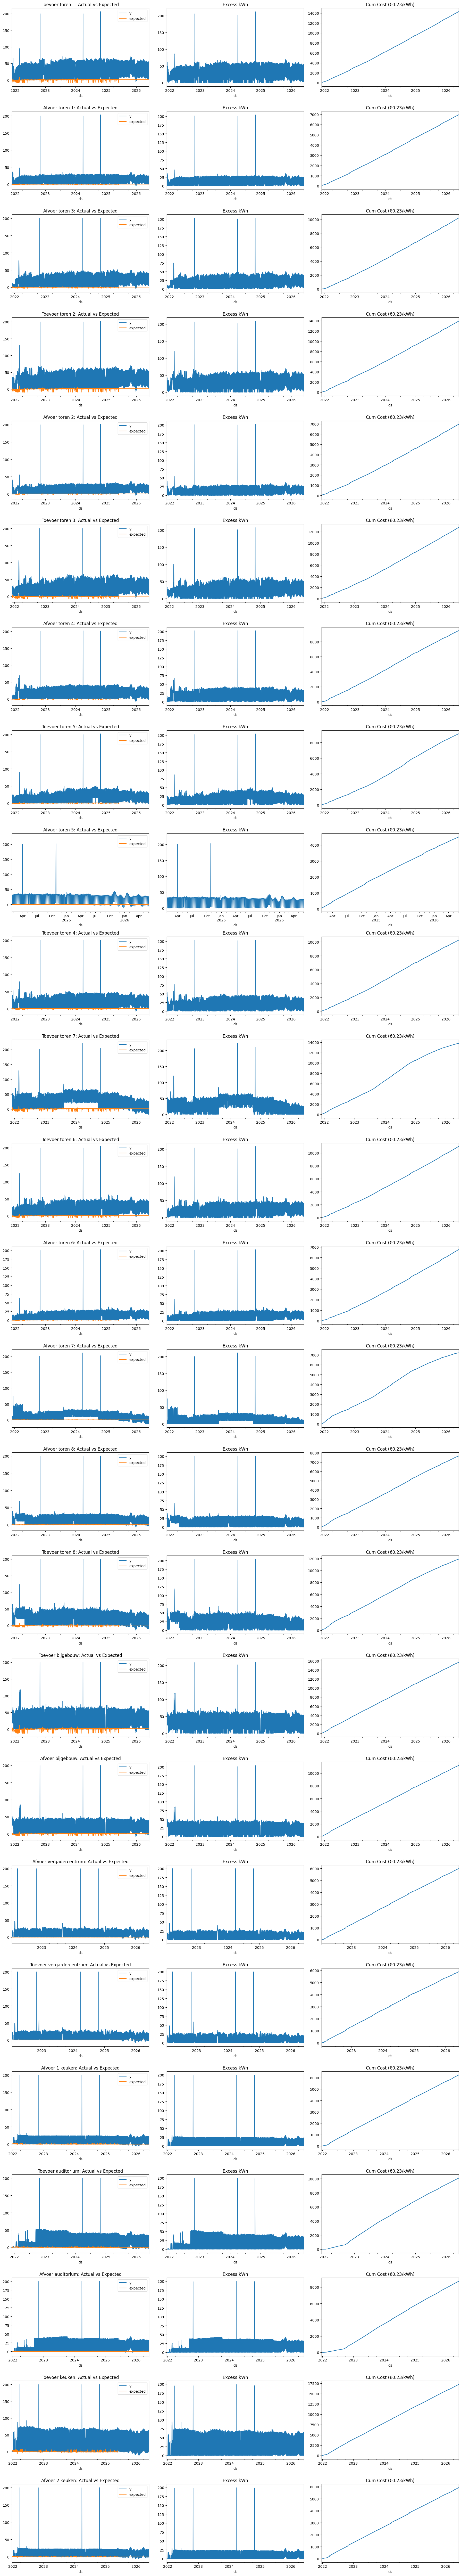

                     channel  baseline_beta_kWh_per_Hz   excess_cost  \
0            Toevoer toren 1                  1.000273  14283.062874   
1             Afvoer toren 1                  0.506658   6949.835199   
2             Afvoer toren 3                  0.660831  10177.880064   
3            Toevoer toren 2                  0.987899  13929.365294   
4             Afvoer toren 2                  0.480154   6958.938257   
5            Toevoer toren 3                  0.817464  12765.129279   
6             Afvoer toren 4                  0.670945   9472.275840   
7            Toevoer toren 5                  0.567106   9115.842832   
8             Afvoer toren 5                  0.676486   4501.202362   
9            Toevoer toren 4                  0.724454  10250.348981   
10           Toevoer toren 7                  1.035933  13804.278404   
11           Toevoer toren 6                  0.735657  10996.241381   
12            Afvoer toren 6                  0.411513   6753.20

In [45]:
forecast_efficiency_weighted('D')      # default baseline=365 days
forecast_efficiency_weighted('W')      # default baseline=52 weeks

df_summary = compute_hvac_inefficiency(
    freq='D',
    baseline_periods=365,
    forecast_periods=365,
    cost_per_kwh=0.23
)
print(df_summary)